**This code is written to compare efficiency of Physics Informed Neural Network compared to casual Neural Network. **![9mI3A.png](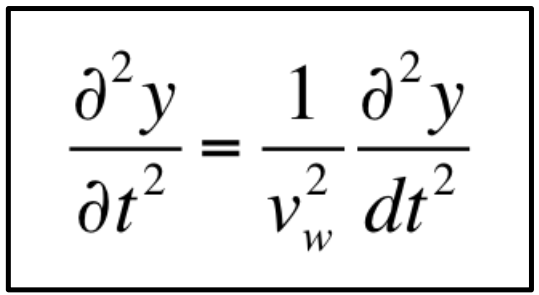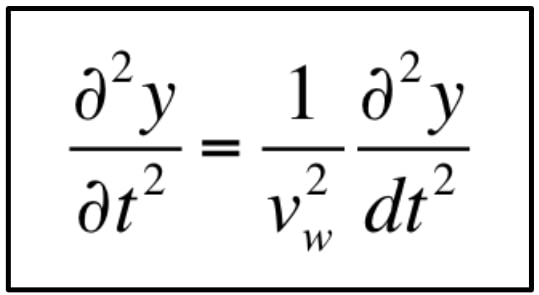)

In [1]:
# importing all packages

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, Dataset
from PIL import Image

In [2]:
# Helper function for saving GIFs

def save_gif_PIL(outfile, files, fps=5, loop=0):
    imgs = [Image.open(file) for file in files]
    imgs[0].save(fp=outfile, format='GIF', append_images=imgs[1:], save_all=True, duration=int(1000/fps), loop=loop)

In [3]:
# This function

def plot_result(x, y, x_data, y_data, file):
  fig, ax = plt.subplots()
  line, = ax.plot(x, y, lw=2)

  # Set plot limits
  ax.set_xlim(0, 2 * wavelength)
  ax.set_ylim(-1.5 * amplitude, 1.5 * amplitude)

  # Set plot labels
  ax.set_xlabel('Position')
  ax.set_ylabel('Amplitude')

  scatter = plt.scatter(x_data, y_data, color="tab:orange", label="Training data")
  line.set_ydata(y)
  plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
  plt.pause(1 / fps)  # Pause to create a smooth animation
  scatter.remove()

In [4]:
# dataset to collect training data points

class MyDataset(Dataset):
    def __init__(self):
        self.x_data = []
        self.time_data = []
        self.y_data = []

    def add_sample(self, x, time, y):
        self.x_data.append(x)
        self.time_data.append(time)
        self.y_data.append(y)

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        return {'x': self.x_data[idx], 'time': self.time_data[idx], 'y': self.y_data[idx]}

In [ ]:
# Function to generate a standing wave
def standing_wave(x, t, wavelength, amplitude):
    wave = amplitude * np.sin(2 * np.pi * x / wavelength) * np.cos(2 * np.pi * t)
    return wave


# Parameters
wavelength = 1.0  # Wavelength of the standing wave
amplitude = 1.0  # Amplitude of the standing wave
speed = 0.5  # Wave propagation speed
duration = 10.0  # Duration of the animation
fps = 30  # Frames per second


dataset = MyDataset()
x = np.linspace(0, 2 * wavelength, 1000)  # Spatial points

# Create an animation
frame = 0
counter = 0
files = []
while frame < fps * duration:
    t = frame / fps * speed  # Time
    y = standing_wave(x, t, wavelength, amplitude)

    x_data = x[0:1000:10]
    y_data = y[0:1000:10]

    file = "plots/standingWave_%.8i.png"%(counter+1)
    plot_result(x, y, x_data, y_data, file)
    files.append(file)


    if (frame+1) % 30 == 0:
      plt.show()
    else: plt.close("all")


    frame += 1
    counter += 1

    for i in range(100):
      dataset.add_sample(x_data[i], t, y_data[i])

print(counter)
save_gif_PIL("standingWave.gif", files, fps=30, loop=0)

In [ ]:
# checking dataset

for i in range(300):
  print(dataset.__getitem__(i))

x_dataset = dataset.x_data
time_dataset = dataset.time_data
y_dataset = dataset.y_data

print(x_dataset)
print(y_dataset)
print(time_dataset)

In [9]:
# model of neural network

class FCN(nn.Module):
    def __init__(self, N_INPUT1, N_INPUT2, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(
            nn.Linear(N_INPUT1 + N_INPUT2, N_HIDDEN),
            activation()
        )
        self.fch = nn.Sequential(
            *[
                nn.Sequential(
                    nn.Linear(N_HIDDEN, N_HIDDEN),
                    activation()
                ) for _ in range(N_LAYERS - 1)
            ]
        )
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)

    def forward(self, x1, x2):
        x = torch.cat((x1, x2), dim=1)  # Concatenate the inputs along the second dimension
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x


In [10]:
# converting datasets to torch tensors

x_dataset = torch.tensor(x_dataset, dtype=torch.float32).view(-1, 1)
time_dataset = torch.tensor(time_dataset, dtype=torch.float32).view(-1, 1).requires_grad_(True)
y_dataset = torch.tensor(y_dataset, dtype=torch.float32).view(-1, 1)

In [11]:
# function to plot result

def plot_result_nn(x, y, file):
  fig, ax = plt.subplots()
  line, = ax.plot(x, y, lw=2)

  # Set plot limits
  ax.set_xlim(0, 2 * wavelength)
  ax.set_ylim(-1.5 * amplitude, 1.5 * amplitude)

  # Set plot labels
  ax.set_xlabel('Position')
  ax.set_ylabel('Amplitude')

  line.set_ydata(y)
  plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
  plt.pause(1 / fps)  # Pause to create a smooth animation

In [ ]:
# creating object of neural network and training it

torch.manual_seed(123)
model = FCN(1, 1, 1, 32, 3)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)

epoch = 20000

for i in range(epoch):
    optimizer.zero_grad()
    yh = model(x_dataset, time_dataset)
    loss = torch.mean((yh-y_dataset)**2)# use mean squared error
    if epoch % 1000 == 0:
        print(f'Epoch {i+1}/{epoch}, Loss: {loss.item()}')
    loss.backward()
    optimizer.step()


In [ ]:
# converting torch tensors into python lists

x_dataset, yh = x_dataset.tolist(), yh.tolist()
print(type(x_dataset))
print(type(yh))

In [ ]:
# checking trained neural network and making gif

files = []
frame = 0


while frame < fps * duration:
  file = "plots_pinn/standingWaveNN_%.8i.png"%(counter+1)
  plot_result_nn(x_dataset[frame * 100:(frame + 1) * 100], yh[frame * 100:(frame + 1) * 100], file)
  files.append(file)


  if (i+1) % 30 == 0:
    plt.show()
  else: plt.close("all")


  frame += 1
  counter += 1

save_gif_PIL("standingWaveNN.gif", files, fps=30, loop=0)

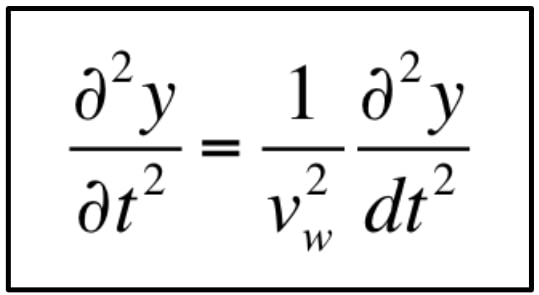

This formula was used as physics loss

In [ ]:
# converting datasets to torch tensors

x_dataset = torch.tensor(x_dataset, dtype=torch.float32).view(-1, 1)
time_dataset = torch.tensor(time_dataset, dtype=torch.float32).view(-1, 1).requires_grad_(True)
y_dataset = torch.tensor(y_dataset, dtype=torch.float32).view(-1, 1)

In [ ]:
# creating object of physics informed neural network

x_physics = torch.linspace(0, 2 * wavelength, 30000).view(-1,1).requires_grad_(True)
torch.manual_seed(123)
model = FCN(1, 1, 1, 32, 3)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)

epoch = 20000

for i in range(epoch):
    optimizer.zero_grad()
    yh = model(x_dataset, time_dataset)
    yhp = model(x_physics, time_dataset)
    # using wave equation to compute physics loss
    dydt  = torch.autograd.grad(yhp, time_dataset, torch.ones_like(yhp), create_graph=True)[0]# computes dy/dx
    d2ydt = torch.autograd.grad(dydt,  time_dataset, torch.ones_like(dydt),  create_graph=True)[0]# computes d^2y/dx^2
    physics_loss = 1 / (speed  **2 ) * d2ydt
    physics_loss = (1e-4) * torch.mean(physics_loss ** 2)
    data_loss = torch.mean((yh - y_dataset) ** 2)  # use mean squared error
    loss = physics_loss + data_loss
    if epoch % 1000 == 0:
        print(f'Epoch {i+1}/{epoch}, Loss: {loss.item()}')
    loss.backward()
    optimizer.step()

In [ ]:
print(physics_loss.item())

In [ ]:
# saving gif of physics informed neural network

files = []
frame = 0
x_dataset, yh = x_dataset.tolist(), yh.tolist()


while frame < fps * duration:
  file = "plots_pinn/standingWaveNN_%.8i.png"%(counter+1)
  plot_result_nn(x_dataset[frame * 100:(frame + 1) * 100], yh[frame * 100:(frame + 1) * 100], file)
  files.append(file)


  if (i+1) % 30 == 0:
    plt.show()
  else: plt.close("all")


  frame += 1
  counter += 1
save_gif_PIL("standingWavePINN.gif", files, fps=30, loop=0)